# Introduction
<br>
**Context**
<br>
This notebook was created to participate in the Kaggle competition "[House prices: Advanced Regression Technique](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)".
<br>


**Objective**
<br>
The goal of the competition was to predict the sale prices of a set of houses.
<br>

**Results**
<br>
On July 26th of 2018, my model was ranked within the top 23%.
<br>

**Litterature**
<br>
This notebook was my very first attempt to build a ML model. I've learnt many things reading other models, such as:
<br>
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python), by Pedro Marcelino

- [A study on regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset), by Julien Cohen-Solal

- [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models), by Alexandru Papiu

- [XGboost tuning](https://www.kaggle.com/tadepalli/xgboost-with-n-trees-autostop-0-12638), by Srini
<br>

<br>
<br>
# 1. Feature engineering
<b>First, let's set up our environment.</b>

In [1]:
# Ignore warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.grid_search import ParameterGrid
from sklearn.linear_model import Ridge, Lasso
import xgboost
from scipy.stats import skew
from scipy.sparse import csc_matrix
from math import sqrt
import matplotlib.pyplot as plt

n_folds = 5
best_score = 10
best_params = None
best_iter = None

train = pd.read_csv("../../../Desktop/Préparation X/train.csv")
test = pd.read_csv("../../../Desktop/Préparation X/test.csv")

** Now, let's clean datasets.**

In [3]:
# Creating polynomials on top 15 existing features

corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
top_15_features = corr.SalePrice[1:16].index.tolist()

for col in top_15_features:
    train[col + '_p2'] = train[col] ** 2
    train[col + '_p3'] = train[col] ** 3
    train[col + '_sq'] = np.sqrt(train[col])
    
    test[col + '_p2'] = test[col] ** 2
    test[col + '_p3'] = test[col] ** 3
    test[col + '_sq'] = np.sqrt(test[col])

In [4]:
# One-hot encoding categorical variables

onehot_encoded_train = pd.get_dummies(train)
onehot_encoded_test = pd.get_dummies(test)

features_missing_in_test = []
for feature in onehot_encoded_train.columns.tolist():
    if feature not in onehot_encoded_test.columns.tolist():
        features_missing_in_test.append(feature)

train, test = onehot_encoded_train.align(onehot_encoded_test,
                                        join='left', 
                                        axis=1)

for feature in features_missing_in_test:
    test[feature] = 0

test = test.drop("SalePrice", axis = 1)

In [5]:
# Dealing with NAs
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [6]:
# Log transforming the target & skewed numeric features

train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_features = train.select_dtypes(exclude = "object").drop("SalePrice", axis = 1).columns.tolist()
skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75].index # WHY 0.75?

train[skewed_features] = np.log1p(train[skewed_features])
test[skewed_features] = np.log1p(test[skewed_features])

In [7]:
# Extract target and format datasets

target = train['SalePrice']
del train['SalePrice']

X = pd.DataFrame(train)
y = pd.DataFrame(target)

# 2. Modelization
**First, let's try both Lasso and Ridge regularizations**.
<br>Based on cross-validation RMSEs, I'll pick the best parameters and then the best model.

In [8]:
# Defining a function that returns the cross-validation RMSE error
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 5))
    return (rmse)

In [9]:
# Finding the best alpha for *Ridge* regression
alphas_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = pd.Series([rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas_ridge], index = alphas_ridge)

## Refine the alpha list, by adding more alphas to test close to the initial best one.
for new_alpha in np.arange(np.argmin(cv_ridge),np.argmin(cv_ridge)*2,np.argmin(cv_ridge)/10):
    if new_alpha not in alphas_ridge:
        alphas_ridge.append(new_alpha)

for new_alpha in np.arange(np.argmin(cv_ridge),0,-np.argmin(cv_ridge)/10):
    if new_alpha not in alphas_ridge:
        alphas_ridge.append(new_alpha)

alphas_ridge = sorted(alphas_ridge)

cv_ridge = pd.Series([rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas_ridge], index = alphas_ridge)

The lower RMSE is 0.126991 and is reached when alpha = 4.


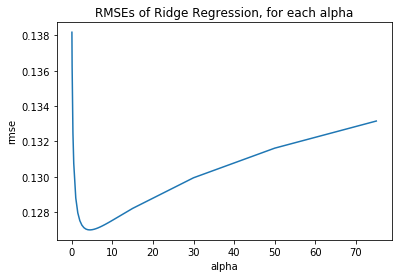

In [10]:
## Plot the results
cv_ridge.plot(title = "RMSEs of Ridge Regression, for each alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print("The lower RMSE is %f and is reached when alpha = %d." %(min(cv_ridge), np.argmin(cv_ridge)))


## Save the results
alpha_ridge = np.argmin(cv_ridge)
rmse_ridge = min(cv_ridge)

The lower RMSE is 0.123586 and is reached when alpha = 0.000300.



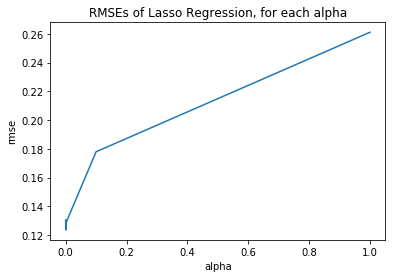

In [11]:
# Finding the best alpha for *Lasso* regression

alphas_lasso = [1, 0.1, 0.001, 0.0005]
cv_lasso = pd.Series([rmse_cv(Lasso(alpha = alpha)).mean()
           for alpha in alphas_lasso], index = alphas_lasso)


## Refine the alpha list, by adding more alphas to test close to the initial best one.
for new_alpha in np.arange(np.argmin(cv_lasso),np.argmin(cv_lasso)*2,np.argmin(cv_lasso)/10):
    if new_alpha not in alphas_lasso:
        alphas_lasso.append(new_alpha)

for new_alpha in np.arange(np.argmin(cv_lasso),0,-np.argmin(cv_lasso)/10):
    if new_alpha not in alphas_lasso:
        alphas_lasso.append(new_alpha)

alphas_lasso = sorted(alphas_lasso)        

cv_lasso = pd.Series([rmse_cv(Lasso(alpha = alpha)).mean()
           for alpha in alphas_lasso], index = alphas_lasso)


## Plot the results
cv_lasso.plot(title = "RMSEs of Lasso Regression, for each alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print("The lower RMSE is %f and is reached when alpha = %f." %(min(cv_lasso), np.argmin(cv_lasso)))
print()


## Save the results
alpha_lasso = np.argmin(cv_lasso)
rmse_lasso = min(cv_lasso)

In [16]:
# Pick the best model
if rmse_lasso > rmse_ridge:
    print("Ridge seems to perform better! We'll be using this regression model.")
    regression_model = Ridge(alpha = alpha_ridge).fit(X,y)

else:
    print("Lasso thus seems to perform better! Let's use this regression model.")
    regression_model = Lasso(alpha = alpha_lasso).fit(X,y)

regression_predictions = np.expm1(regression_model.predict(test))

Lasso thus seems to perform better! Let's use this regression model.


<br>**Now, let's try to improve our score by adding an XGBoost model**.
<br><br>
First, let's find the best parameters.

In [12]:
# Spliting the train dataset into 5 folds
train_array = np.array(X)
target_array = np.array(y)

kfold = KFold(train_array.shape[0], n_folds)
early_stopping = 50

# Creating the sets of parameters we want to test
param_grid = [
              {'silent': [1],
               'nthread': [2],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [5, 7],
               'num_round': [1000],
               'subsample': [0.2, 0.4, 0.6],
               'colsample_bytree': [0.3, 0.5, 0.7],
               }
              ]


# Computing RMSLE for every set of parameter
for params in ParameterGrid(param_grid):
    print(params)
    
    ## 1. Determine best n_rounds
    xgboost_rounds = []
    for train_index, test_index in kfold:
        X_train, X_test = train_array[train_index], train_array[test_index]
        y_train, y_test = target_array[train_index], target_array[test_index]

        xg_train = xgboost.DMatrix(X_train, label=y_train)
        xg_test = xgboost.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        num_round = params['num_round']
        
        xgclassifier = xgboost.train(params, xg_train, num_round,
                                     watchlist,
                                     early_stopping_rounds=early_stopping,
                                     verbose_eval=False);
        
        xgboost_rounds.append(xgclassifier.best_iteration)

    num_round = int(np.mean(xgboost_rounds))
    print('The best n_rounds is %d' % num_round)
    
    ## 2. Compute RMSLE
    rmsle_score = []
    for cv_train_index, cv_test_index in kfold:
        X_train, X_test = train_array[cv_train_index, :], train_array[cv_test_index, :]
        y_train, y_test = target_array[cv_train_index], target_array[cv_test_index]

        xg_train = xgboost.DMatrix(X_train, label=y_train)
        xg_test = xgboost.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]

        xgclassifier = xgboost.train(params, xg_train, num_round,verbose_eval=False);

        predicted_results = xgclassifier.predict(xg_test)
        rmsle_score.append(np.sqrt(mean_squared_error(y_test, predicted_results)))
    
    ## 3. If the RMSLE is better than the current best, best_params will take these parameters.
    if best_score > np.mean(rmsle_score):
        print(np.mean(rmsle_score))
        print('new best')
        best_score = np.mean(rmsle_score)
        best_params = params
        best_iter = num_round


# Storing the best parameters
print('best params: %s' % best_params)
print('best score: %f' % best_score)
xg_train = xgboost.DMatrix(train_array, label=target_array)
xg_test = xgboost.DMatrix(test)
watchlist = [(xg_train, 'train')]
num_round = best_iter

{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.2}
The best n_rounds is 482
0.1254476945368983
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}
The best n_rounds is 544
0.12099796218823644
new best
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}
The best n_rounds is 631
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.2}
The best n_rounds is 489
{'colsample_bytree': 0.3, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4

In [13]:
best_params = {'colsample_bytree': 0.7,
 'eta': 0.03,
 'eval_metric': 'rmse',
 'max_depth': 5,
 'nthread': 2,
 'num_round': 1000,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.6}

num_rounds = 625

Now, let's build our XGBoost model.

In [14]:
# Building XGBoost model
xg_train = xgboost.DMatrix(X, y)
watchlist = [(xg_train, 'train')]
xgb_model = xgboost.train(best_params, xg_train, num_rounds, watchlist, verbose_eval=False)

# Predicting prices for test set
xg_test = xgboost.DMatrix(test)
xgb_predictions = np.expm1(xgb_model.predict(xg_test))

**Last, let's create our submission file.**

In [17]:
predictions = 0.5 * regression_predictions + 0.5 * xgb_predictions

In [18]:
submission = pd.DataFrame.from_csv('../../../Desktop/Préparation X/sample_submission.csv')
submission['SalePrice'] = predictions
print(submission.head())

          SalePrice
Id                 
1461  121568.796155
1462  157245.095539
1463  182849.705278
1464  195613.032965
1465  188388.757104


In [19]:
submission.to_csv('submission.csv', index=True)